# Imports

In [17]:
import os

from bumps.cli import load_model, load_best
from molgroups.support import molstat

# Variables

Variables to set the storage folder for the fit, the base name of the runfile, and the global optimizer. Further the
number of burn and production stepst for the MCMC are set. The run flag determines whether the refl1d MCMC is run, or
just a data analysis on a previous fit is performed.

Steps (and burn) are intentionally small in this example to reduce file sizes.

In [18]:
setupdir = os.getcwd()
store = "fit"
runfile = "ssblm"
fitsource = "refl1d"

if not os.path.isdir(store):
    os.mkdir(store)

run = False
burn = 500
steps = 500


# Example Fit

The content of the following cell is written out to the runfile of the fit 'tblm.py'.

In [19]:
%%writefile ssblm.py
## === Import section ===

import sys
import numpy as np
from molgroups import mol
from molgroups import components as cmp
from molgroups import lipids
from refl1d.names import load4, Parameter, SLD, Slab, Experiment, FitProblem
from refl1d.flayer import FunctionalProfile

## === Film structure definition section ===

### Bilayer profile definition function

def bilayer(z, sigma, bulknsld, global_rough, rho_substrate, l_submembrane, l_lipid1, l_lipid2, vf_bilayer):
    """ Fairly generic bilayer. This assumes a stack of materials already existing because siox.l is set to zero """

    # Set unused parameters
    l_siox = 0.0 # could make a parameter in the future
    rho_siox = 0.0

    # Scale all SLDs from Refl1D units (1e-6 Ang^-2) to molgroups units (Ang^-2)
    bulknsld *= 1e-6
    rho_substrate *= 1e-6

    blm.fnSet(sigma=sigma, bulknsld=bulknsld, global_rough=global_rough, rho_substrate=rho_substrate, rho_siox=rho_siox, l_siox=l_siox, l_submembrane=l_submembrane, l_lipid1=l_lipid1, l_lipid2=l_lipid2, vf_bilayer=vf_bilayer)

    # Calculate scattering properties of volume occupied by bilayer
    normarea, area, nsl = blm.fnWriteProfile(z)

    # Fill in the remaining volume with buffer of appropriate nSLD
    nsld = nsl / (normarea * np.gradient(z)) + (1.0 - area / normarea) * bulknsld

    # export objects for post analysis, needs to be from this function
    problem.bilayers = [blm]
    problem.dimension = dimension
    problem.stepsize = stepsize
    problem.moldat = blm.fnWritePar2Dict({}, 'bilayer', np.arange(dimension) * stepsize)

    # Return nSLD profile in Refl1D units
    return nsld*1e6

### Define bilayer parameters
vf_bilayer = Parameter(name='volume fraction bilayer', value=0.9).range(0.0, 1.0)
l_lipid1 = Parameter(name='inner acyl chain thickness', value=10.0).range(8, 16)
l_lipid2 = Parameter(name='outer acyl chain thickness', value=10.0).range(8, 16)
sigma = Parameter(name='bilayer roughness', value=5).range(2, 9)
global_rough = Parameter(name ='tiox roughness', value=5).range(2, 9)
l_tiox = Parameter(name='total tiox thickness', value=120).range(50, 150)
l_submembrane = Parameter(name='submembrane thickness', value=10).range(0, 50)

### Define bilayer object
DOPC = cmp.Lipid(name='DOPC', headgroup=lipids.PC, tails=[cmp.oleoyl, cmp.oleoyl], methyls=cmp.methyl)
blm = mol.ssBLM(lipids=[DOPC], lipid_nf=[1.0])

### Define molgroups space.
dimension=300       # Number of steps
stepsize=0.5        # Length of steps

## === Stack ===
##
## First, we create a 'material' for each bulk layer, which has an real and imaginary
## scattering length density, stored in a Refl1d object called 'SLD'
d2o = SLD(name='d2o', rho=6.3000, irho=0.0000)
h2o = SLD(name='h2o', rho=-0.56, irho=0.0000)
tiox = SLD(name='tiox', rho=2.1630, irho=0.0000)
siox = SLD(name='siox', rho=4.1000, irho=0.0000)
silicon = SLD(name='silicon', rho=2.0690, irho=0.0000)

## Then bulk layers are created, each with its own 'material'.  If you want to force
## two layers to always match SLD you can use the same material in multiple layers.
## The roughnesses of each layer are set to zero to begin with:

layer_d2o = Slab(material=d2o, thickness=0.0000, interface=5.0000)
layer_h2o = Slab(material=h2o, thickness=0.0000, interface=5.0000)
layer_tiox = Slab(material=tiox, thickness=l_tiox - (blm.substrate.z + 0.5 * blm.substrate.l), interface=0.0)
layer_siox = Slab(material=siox, thickness=7.5804, interface=10.000)
layer_silicon = Slab(material=silicon, thickness=0.0000, interface=0.0000)

## Use the bilayer definition function to generate the bilayer SLD profile, passing in the relevant parameters.
## Note that substrate and bulk SLDs are linked to their respective materials.
mollayer = FunctionalProfile(dimension*stepsize, 0, profile=bilayer, sigma=sigma,
                                bulknsld=d2o.rho, global_rough=global_rough, rho_substrate=tiox.rho,
                                l_submembrane=l_submembrane, l_lipid1=l_lipid1, l_lipid2=l_lipid2,
                                vf_bilayer=vf_bilayer)
mollayerh = FunctionalProfile(dimension*stepsize, 0, profile=bilayer, sigma=sigma,
                                bulknsld=h2o.rho, global_rough=global_rough, rho_substrate=tiox.rho,
                                l_submembrane=l_submembrane, l_lipid1=l_lipid1, l_lipid2=l_lipid2,
                                vf_bilayer=vf_bilayer)

## Stack the layers into individual samples, using common layer objects for layers that are unchanged between samples
## As a convention, always build the sample from the substrate up. If the neutron beam is incident from the substrate side,
## set back_reflectivity = True in the probe definition later.

sample = layer_silicon | layer_siox | layer_tiox | mollayer | layer_d2o
sampleh = layer_silicon | layer_siox | layer_tiox | mollayerh | layer_h2o

## Set sample parameter ranges and constraints between layer properties

# nSLD parameters
d2o.rho.range(5.3000, 6.5000)
h2o.rho.range(-0.6, 0.6)
tiox.rho.range(1.1630, 3.1630)
siox.rho.range(3.1000, 5.1000)

# layer thickness parameters
layer_tiox.thickness.range(66.379, 266.38)
layer_siox.thickness.range(5, 40)

# layer roughness parameters
###################################################################
## the 'interface' associated with layer0 is the boundary between #
## layer0 and layer1, and similarly for layer(N) and layer(N+1)   #
###################################################################
layer_siox.interface.range(2.0000, 9.000)

# Si and SiOx roughnesses are the same
layer_silicon.interface = layer_siox.interface

## === Data files ===
probe = load4('../noBLM/ch061.refl', back_reflectivity=True)
probeh = load4('../noBLM/ch060.refl', back_reflectivity=True)

# Set instrumental (probe) parameters
probe.background.range(-1e-7, 1e-5)
probeh.background.range(-1e-7, 1e-5)
probe.intensity.range(0.9, 1.05)
probeh.intensity = probe.intensity
probe.theta_offset.range(-0.015, 0.005)
probeh.theta_offset = probe.theta_offset
probe.sample_broadening.range(-0.005, 0.02)
probeh.sample_broadening = probe.sample_broadening

# Define critical edge oversampling for samples that require it
probe.critical_edge(substrate=silicon, surface=d2o)

## === Problem definition ===
## a model object consists of a sample and a probe.

## step = True corresponds to a calculation of the reflectivity from an actual profile
## with microslabbed interfaces.  When step = False, the Nevot-Croce
## approximation is used to account for roughness.  This approximation speeds up
## the calculation tremendously, and is reasonably accuarate as long as the
## roughness is much less than the layer thickness
step = False

model = Experiment(sample=sample, probe=probe, dz=stepsize, step_interfaces = step)
modelh = Experiment(sample=sampleh, probe=probeh, dz=stepsize, step_interfaces = step)

problem = FitProblem([model, modelh])

## === Export objects for post analysis ===
problem.name = "DOPC bilayer on TiOx substrate"
problem.bilayers = [blm]
problem.dimension = dimension
problem.stepsize = stepsize

Overwriting ssblm.py


# Running the fit

The following runs the fit using rs.py. It can also be run manually from the command line using, for example:
> refl1d_cli.py tblm.py --fit=dream --init=lhs --parallel --store=fit --burn=16000 --steps=500

In [20]:
if run:
    if os.path.isfile(store + "/sErr.dat"):
        os.remove(store + "/sErr.dat")
    if os.path.isfile(store + "/isErr.dat"):
        os.remove(store + "/isErr.dat")
    if os.path.isfile(store + "/StatDataPython.dat"):
        os.remove(store + "/StatDataPython.dat")

fit_object = molstat.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=None,
    problem=None
)

if run:
    fit_object.Interactor.fnRunMCMC(burn, steps, batch=False)

# Analysis

Statistical analysis of fit results.

Median values, 68% confidence limits (-1, 94%: -2, etc.), and fit intervals for all fit parameters.

In [21]:
sparse = 0.05
fit_object.fnAnalyzeStatFile(fConfidence=-1, sparse=sparse)

No StatDataPython.dat.
Recreate statistical data from sErr.dat.
Found sErr.dat

Analysis of current MC simulation ...
Number of iterations: 4497
          background_ch061  [|+         ]  [    -1e-07,     1e-05]  [ 2.889e-07(0.000),  7.127e-07(0.000),  1.008e-06(0.000)] (- 4.239e-07, + 2.953e-07)
           intensity_ch061  [    | - |  ]  [       0.9,      1.05]  [    0.9669(0.000),     0.9905(0.000),      1.013(0.000)] (-    0.0236, +   0.02218)
   sample_broadening_ch061  [ | - |     ]  [    -0.005,      0.02]  [ -0.001943(0.000),   0.002516(0.000),   0.007136(0.000)] (-   0.00446, +   0.00462)
        theta_offset_ch061  [  |  - |   ]  [    -0.015,     0.005]  [  -0.01186(0.000),  -0.005937(0.000),  -0.000228(0.000)] (-  0.005918, +  0.005709)
            siox_interface  [  | - |    ]  [         2,         9]  [     3.146(0.000),      4.624(0.000),      6.273(0.000)] (-     1.478, +     1.648)
                  siox_rho  [ |-  |     ]  [       3.1,       5.1]  [     3.207(0.000),   

Create bilayer statistics from above parameter statistics. Results are saved to bilayerplotdata.dat.

In [22]:
fit_object.fnCreateBilayerPlotData()

Initializing ...
Pulling all molgroups ...
  substrate ...
  siox ...
  tether ...
Molecular group bilayer.bME does not exist.
Molecular group bilayer.tetherg does not exist.
Molecular group bilayer.tether does not exist.
Molecular group bilayer.tether_bme does not exist.
Molecular group bilayer.tether_free does not exist.
Molecular group bilayer.tether_hg does not exist.
  innerhg ...
  innerhc ...
Molecular group bilayer.tether_methylene does not exist.
Molecular group bilayer.tether_methyl does not exist.
Molecular group bilayer.tether_methylene does not exist.
Molecular group bilayer.tether_methyl does not exist.
  outerhc ...
  outerhg ...
  protein ...
Molecular group protein does not exist.
Applying corrections ...

Calculating statistics ...

Saving data to bilayerplotdata.dat ...



Plot selected data from bilayerplotdata.dat

> _cvo is component volume occupancy data [0 ,1] opposed to area profiles [0, area per lipid outer leaflet].

> _corr is corrected data taking into account bilayer material replacement by protein (not applicable here, but does not
> hurt)

> cg, phos, and chol subgroups of the PC headgroup are currently only extracted for the first lipid component, to help
with certain applications. They are not scaled down according to the scaling factor of the parent headgroup and
represent the area of one subgroup.

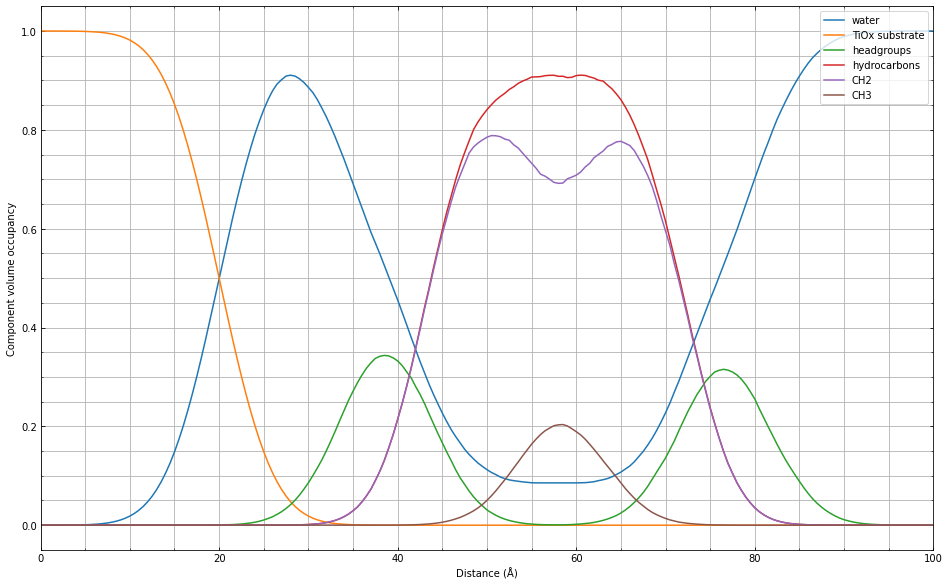

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

bilayer_plot_data = pd.read_csv(store + "/bilayerplotdata.dat", sep="\s", engine="python")

zax = bilayer_plot_data["zaxis"]

fig, ax = plt.subplots()
ax.plot(zax, bilayer_plot_data["water_corr_cvo"], label="water")
ax.plot(zax, bilayer_plot_data["substrate_corr_cvo"], label="TiOx substrate")
ax.plot(zax, bilayer_plot_data["innerhg_corr_cvo"] + bilayer_plot_data["outerhg_corr_cvo"], label="headgroups")
ax.plot(zax, bilayer_plot_data["innerhc_corr_cvo"]+bilayer_plot_data["outerhc_corr_cvo"], label="hydrocarbons")
ax.plot(zax, bilayer_plot_data["innerch2_corr_cvo"]+bilayer_plot_data["outerch2_corr_cvo"], label="CH2")
ax.plot(zax, bilayer_plot_data["innerch3_corr_cvo"]+bilayer_plot_data["outerch3_corr_cvo"], label="CH3")
ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("Component volume occupancy")
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
plt.xlim(0, 100)
plt.grid(True, which='Both')
fig.patch.set_facecolor('white')
ax.figure.set_size_inches(16, 10)
plt.savefig(store + "/cvo", facecolor="white")
plt.show()

Compute statistical properties of interest with 68% confidence limits, such as the area per lipid of the outer lipid
leaflet.

In [24]:
fit_object.fnCalculateMolgroupProperty(fConfidence=-1)

Did not find any fractional envelopes ...
WaterFracHeadgroup1  [     0.495,     0.5331,     0.5737] (-   0.03814, +   0.04055)
WaterFracHeadgroup2  [    0.4995,     0.5336,     0.5662] (-   0.03408, +   0.03262)
WaterFracHydrocarbon  [    0.1035,     0.1183,     0.1356] (-   0.01475, +    0.0173)
WaterFracLipid1  [   0.09711,     0.1189,     0.1417] (-   0.02179, +   0.02275)
WaterFracLipid2  [    0.1015,     0.1216,     0.1432] (-   0.02011, +   0.02163)
WaterFracSubMembrane  [    0.9696,     0.9786,     0.9868] (-  0.009006, +  0.008218)
bilayer.defect_hc_AVG  [   0.09998,     0.2361,     0.3481] (-    0.1361, +     0.112)
bilayer.defect_hc_COM  [     57.01,      57.68,      58.34] (-    0.6754, +    0.6547)
bilayer.defect_hc_INT  [    0.2013,     0.5105,     0.7732] (-    0.3092, +    0.2627)
bilayer.defect_hg_AVG  [   0.03538,    0.07966,     0.1118] (-   0.04428, +   0.03214)
bilayer.defect_hg_COM  [     61.79,      62.47,      63.12] (-    0.6754, +    0.6547)
bilayer.defect_hg_I

,element,lower_conf,median,upper_conf
0,WaterFracHeadgroup1,0.494969,0.533107,0.573654
1,WaterFracHeadgroup2,0.499535,0.533614,0.566231
2,WaterFracHydrocarbon,0.103516,0.118268,0.135563
3,WaterFracLipid1,0.097114,0.118908,0.141658
4,WaterFracLipid2,0.101454,0.121561,0.143190
5,WaterFracSubMembrane,0.969577,0.978583,0.986801
6,bilayer.defect_hc_AVG,0.099984,0.236109,0.348105
7,bilayer.defect_hc_COM,57.005244,57.680677,58.335382
8,bilayer.defect_hc_INT,0.201257,0.510480,0.773168
9,bilayer.defect_hg_AVG,0.035381,0.079664,0.111807


A simple way to show output files from the fit. Publication-ready graphs can be created from the data in the storage
directory or using fit_object:

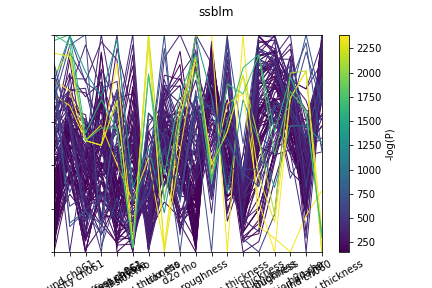

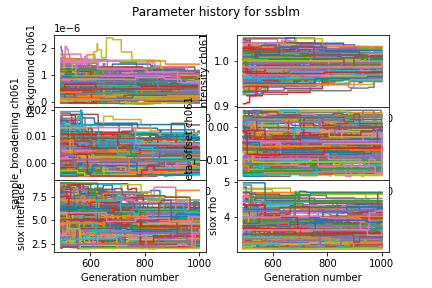

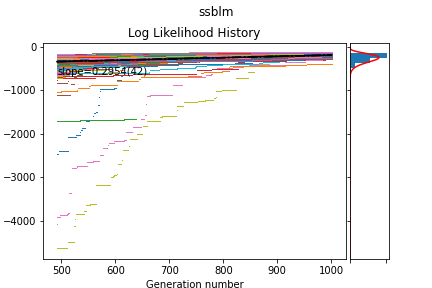

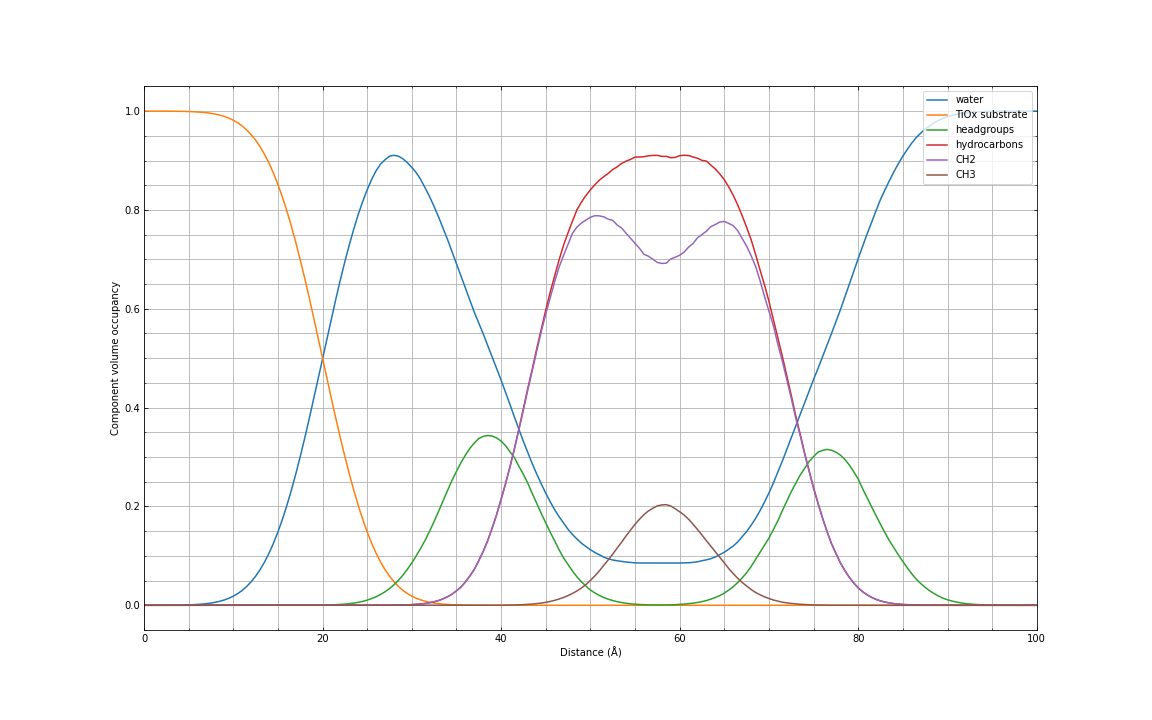

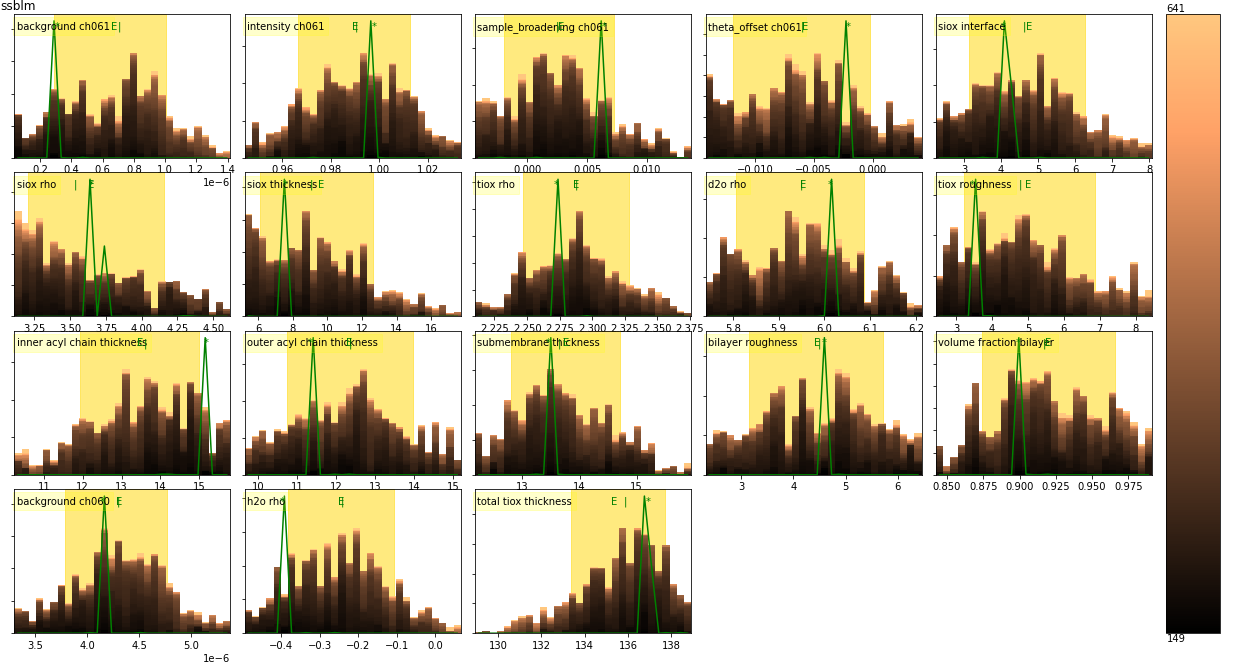

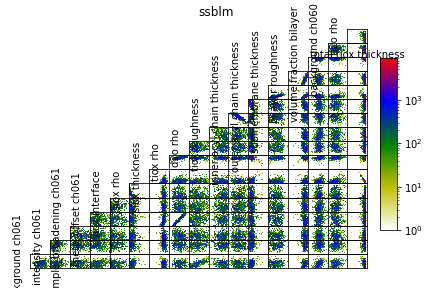

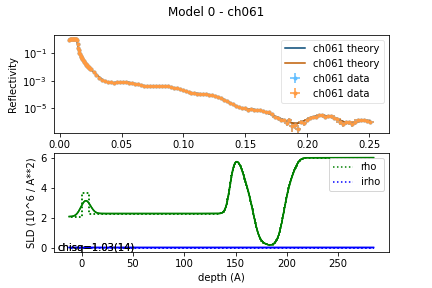

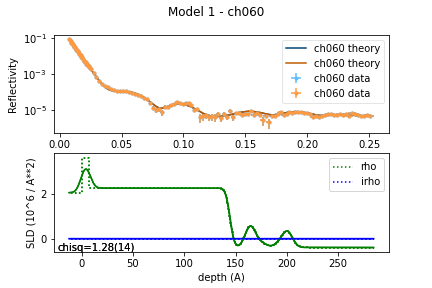

In [25]:
from IPython.display import Image, display
import glob
for file in glob.glob(store+"/*.png"):
    display(Image(filename=file))


# Publication-ready graphs

...

# Useful Routines


Create a HC18 / POPC tethered lipid membrane object and manually change model parameters. Show the molecular
distributions.

In [26]:
blm = mol.tBLM(tether=lipids.HC18SAc, filler=cmp.bmeSAc, lipids=[lipids.POPC], lipid_nf=[1.0])
blm.l_tether = 20.
#blm.fnSetSigma(0.001)
#blm.global_rough=0.001
#blm.tether_methyl_sigma=0.001
#blm.methyl_sigma = blm.methyl_sigma/2.0*0.001
blm.fnAdjustParameters()

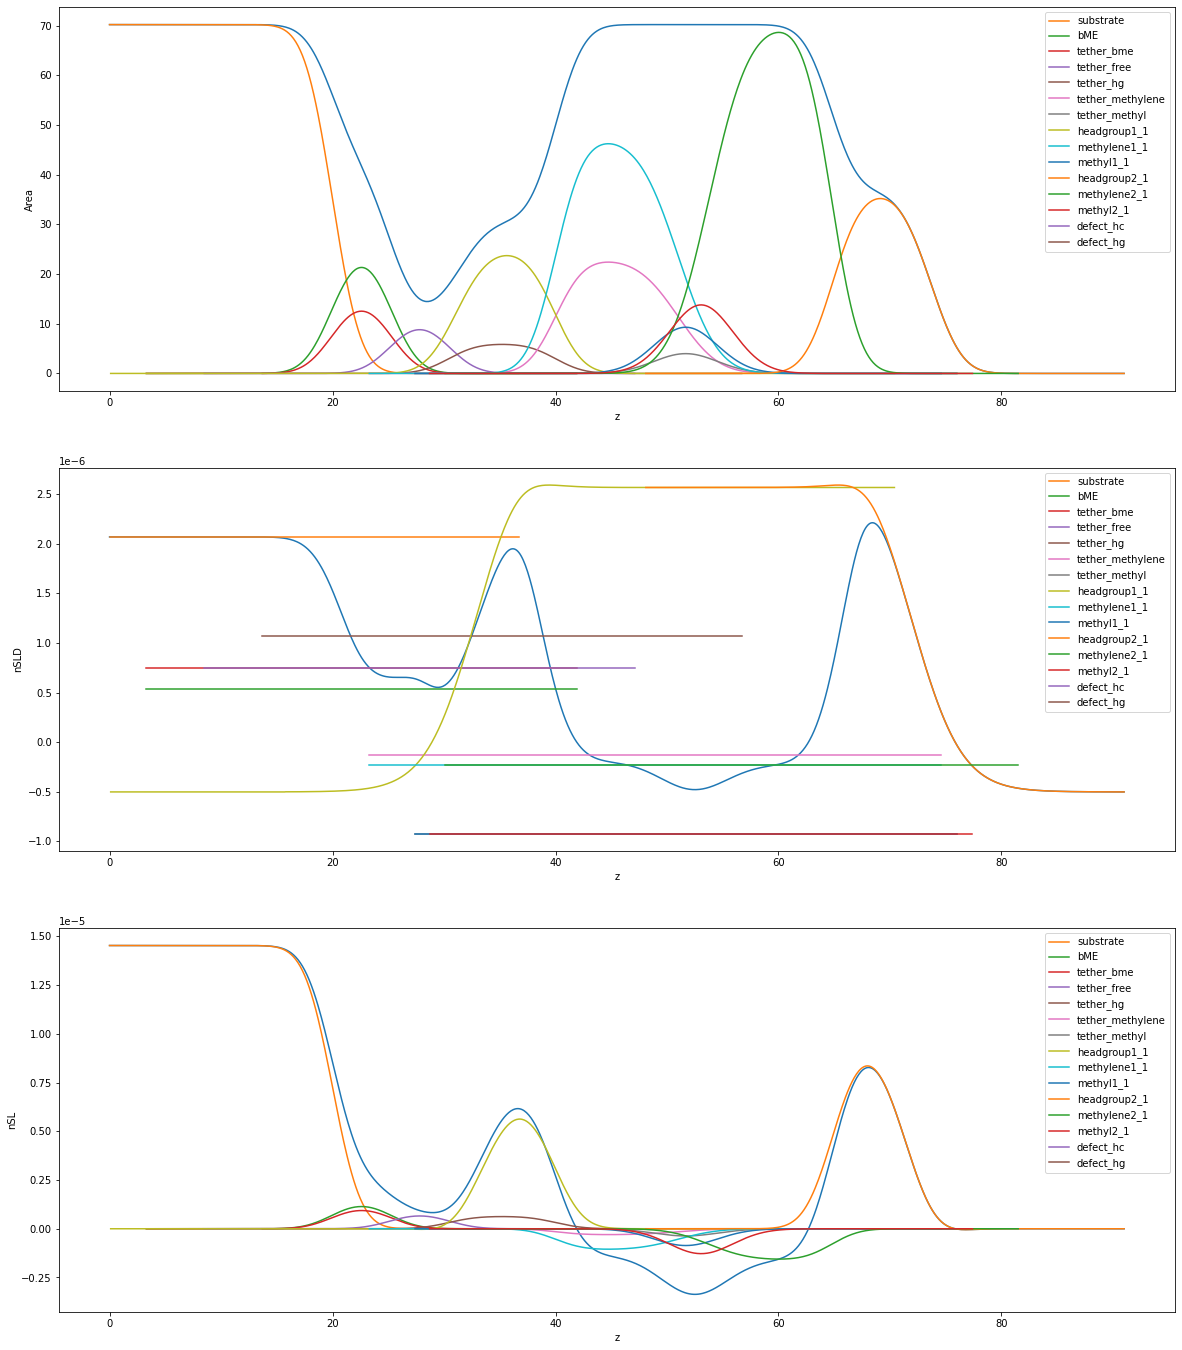

In [27]:
def plot_components(z, blm):
    dd, aArea, anSL = blm.fnWriteProfile(z)
    aArea = np.array(aArea)
    anSL = np.array(anSL)
    sel = aArea>0
    anSLD = anSL[sel] / (aArea[sel] * stepsize)

    fig, ax = plt.subplots(3, 1, figsize=(20,24))
    fig.patch.set_facecolor('white')
    ax[0].plot(z[sel], aArea[sel])
    ax[1].plot(z[sel], anSLD)
    ax[2].plot(z[sel], anSL[sel])
    ax[0].set_ylabel('Area')
    ax[1].set_ylabel('nSLD')
    ax[2].set_ylabel('nSL')
    ax[0].set_xlabel('z')
    ax[1].set_xlabel('z')
    ax[2].set_xlabel('z')

    # plot individual components
    for key, val in blm.__dict__.items():       # cycle over all attributes of blm
        if isinstance(val, mol.nSLDObj):        # if instance of nSLDObj, plot its profile
            ddp, aArea, anSL = val.fnWriteProfile(z)
            aArea = np.array(aArea)
            anSL = np.array(anSL)
            sel = aArea>0
            anSLD = anSL[sel] / (aArea[sel] * stepsize)
            ax[0].plot(z[sel], aArea[sel], '-', label=val.name)
            ax[1].plot(z[sel], anSLD, '-', label=val.name)
            ax[2].plot(z[sel], anSL[sel], '-', label=val.name)

    ax[0].legend(loc=0)
    ax[1].legend(loc=0)
    ax[2].legend(loc=0)

dimension = 1500
stepsize =0.1
z = np.arange(dimension) * stepsize
plot_components(z, blm)

Load the best-fit tBLM profile and show it.

In [28]:
model = load_model(runfile+'.py')
load_best(model, store+'/'+runfile+'.par')
model.chisq_str()

'1.243(84)'

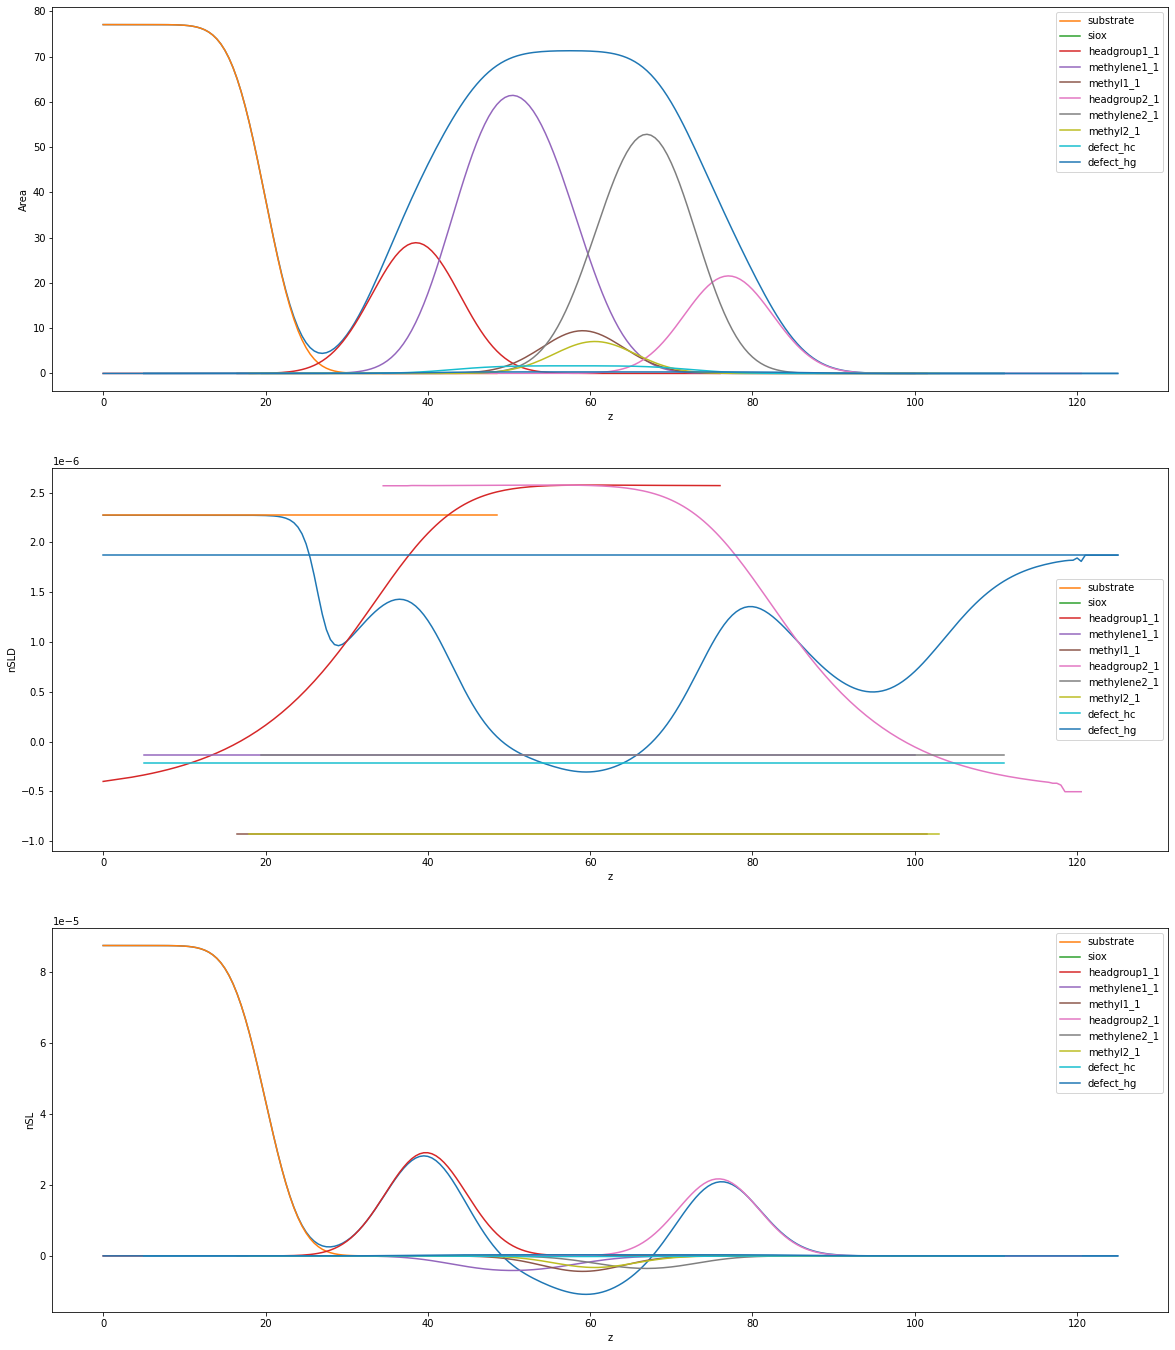

In [29]:
z = np.arange(model.dimension) * model.stepsize
stepsize = model.stepsize
blm = model.bilayers[0]

plot_components(z, model.bilayers[0])